In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, noise, seaborn as sns
from skimage.morphology import (disk, ball)
from skimage.filters import threshold_isodata, roberts

In [2]:
# COMMENT THIS OUT IF SETTING RADIUS ABOVE 5
# pd.set_option('display.max_columns', None)

In [3]:
# Set Radius of island and island seed
seed = 14
r = 100
pond_cutoff = 10
rook_adjacency = False

In [4]:
d = (r*2)
ponds = []
pond_pixels = []

In [5]:
# Define Pixel class for each tile of heightmap
class Pixel:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.vol = 0.1
        self.pointer = self
        
    def to_string(self):
        return (self.x, self.y, self.z)

In [6]:
# Pond Class definition
class Pond:
    def __init__(self, origin):
        self.members = [origin]
        self.level = origin.z
        self.pointer = origin
        self.vol = 0
        self.edges = [origin]
    def rise(self):
        get_edges(self)
        while True:
            self.pointer = get_pond_pointer(self)
            if self.pointer.z > self.level:
                for pond in ponds:
                    if pond == self:
                        continue
                    if (self.pointer in pond.members) or (self.pointer in pond.edges):
                        if self.pointer not in pond.members:
                            self.members.append(self.pointer)
                        pond.members += self.members
                        for edge in self.edges:
                            if (edge not in pond.edges) and (edge not in pond.members):
                                pond.edges.append(edge)
                        for edge in pond.edges:
                            if (edge in self.members):
                                pond.edges.remove(edge)
                        ponds.remove(self)
                        break
                if self in ponds:
                    get_edges(self)
                    self.level = self.pointer.z
                    for member in self.members:
                        member.z = self.level
                    self.members.append(self.pointer)
                    if self.pointer in self.edges:
                        self.edges.remove(self.pointer)
                else:
                    break
            else:
                break
                
    def vol_update(self):
        self.vol = 0.1*len(self.members)
        inflows = self.edges
        for inflow in inflows:
            if inflow.pointer in self.members:
                self.vol += inflow.vol

In [7]:
# Function to get z value from given object
def get_z(arg):
    return arg.z

In [8]:
# Function to get adjacent pixels
def get_adjacents(pixel):
    x = pixel.x
    y = pixel.y
    adjacents = []
    if rook_adjacency == False:
        for i in range(3):
            for j in range(3):
                adjacents.append(pancake[y-1+i][x-1+j])
    else:
        adjacents.append(pancake[y-1][x])
        adjacents.append(pancake[y+1][x])
        adjacents.append(pancake[y][x-1])
        adjacents.append(pancake[y][x+1])
        adjacents.append(pixel)
    return adjacents

In [9]:
# Function to update pixel pointer
def get_pointer(pixel):
    to_beat = 999999999
    lowest = pixel
    for adj in get_adjacents(pixel):
        if adj.z <= to_beat:
            to_beat = adj.z
            lowest = adj
    return lowest

In [10]:
# Function to update pond edges
def get_edges(pond):
    adjs = get_adjacents(pond.pointer)
    for adj in adjs:
        if (adj not in pond.edges) and (adj not in pond.members) and (adj in eclair):
            pond.edges.append(adj)
    pond.edges.remove(pond.pointer)

In [11]:
# Function to return pond pointer
def get_pond_pointer(pond):
    to_beat = 999999999
    lowest = pond.members[0]
    for edge in pond.edges:
        if edge.z <= to_beat:
            to_beat = edge.z
            lowest = edge
    return lowest

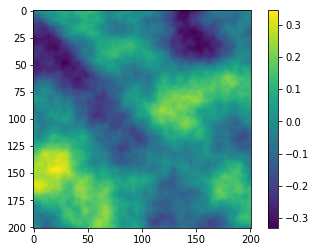

In [12]:
# Code adapted from https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401 to generate perlin using Noise module
shape = (d+1,d+1)
scale = r
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=seed)
        
plt.imshow(world)
plt.colorbar();

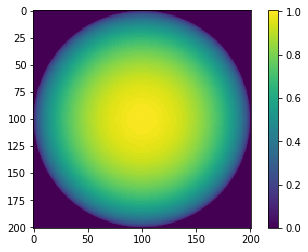

In [13]:
# Generate ball, flatten to 2d array
bosco = ball(r)
biscotti = np.sum(bosco, axis=1)/(d)
plt.imshow(biscotti)
plt.colorbar();

In [14]:
# # Truncation (commented out, we don't love the effect)
# for i in range(len(biscotti)):
#     for j in range(len(biscotti)):
#         if biscotti[i][j] > 0.6:
#             biscotti[i][j] = 0.6

# plt.imshow(biscotti)
# plt.colorbar();

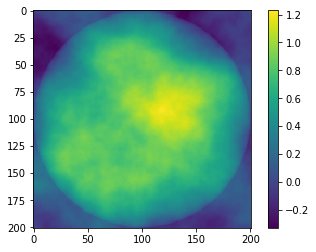

In [15]:
# Combine world and dome to create textured dome
biscuit_land = world+biscotti
plt.imshow(biscuit_land)
plt.colorbar();

In [16]:
# Set inundation level based on median altitude and make sea level 0 elevation
flood = np.median(biscuit_land)
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        biscuit_land[i][j] -= flood

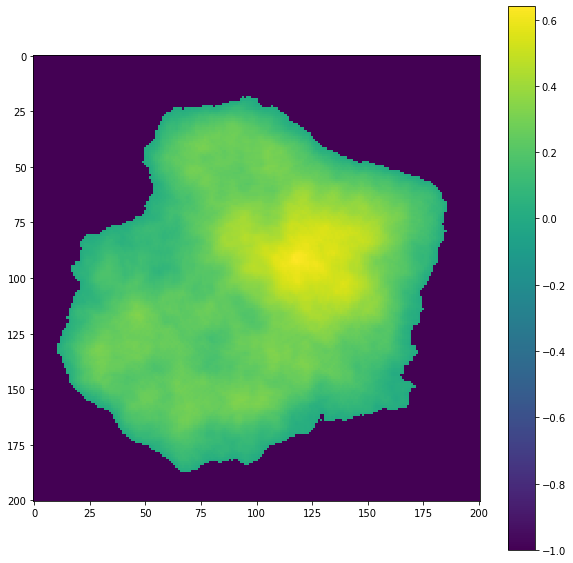

In [17]:
# Inundation visualization
dunked_biscuit = np.zeros((d+1,d+1))
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if biscuit_land[i][j] < 0:
            dunked_biscuit[i][j] = -1
        else:
            dunked_biscuit[i][j] = biscuit_land[i][j]

plt.figure(figsize=(10,10))
plt.imshow(dunked_biscuit)
plt.colorbar();

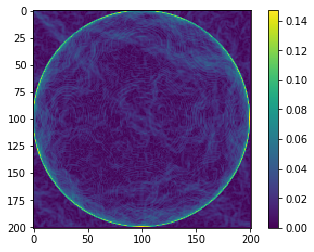

In [18]:
# Roberts edge detection to determine slopes, this will be used later
croissant = roberts(biscuit_land)
            
plt.imshow(croissant)
plt.colorbar();

In [19]:
# Create array of Pixels
pancake = np.empty(biscuit_land.shape, Pixel)
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        pancake[i][j] = (Pixel(j, i, biscuit_land[i][j]))

In [20]:
# Create list of Pixels from array, excluding edge pixels
eclair = []
for i in range(1, d):
    for j in range(1,d):
        eclair.append(pancake[i][j])

In [21]:
# Sort list of pixels by elevation
eclair.sort(key=get_z, reverse=True)

In [22]:
# Initial Flow
for pixel in eclair:
    pixel.pointer = get_pointer(pixel)
    if pixel.pointer != pixel:
        pixel.pointer.vol += pixel.vol

In [23]:
# Initial Pond Creation
for pixel in eclair:
    if (pixel.pointer == pixel) and (pixel.vol >= pond_cutoff) and (pixel.z >= 0):
        new_pond = Pond(pixel)
        ponds.append(new_pond)
        new_pond.rise()
for pond in ponds:
    for member in pond.members:
        if member not in pond_pixels:
            pond_pixels.append(member)

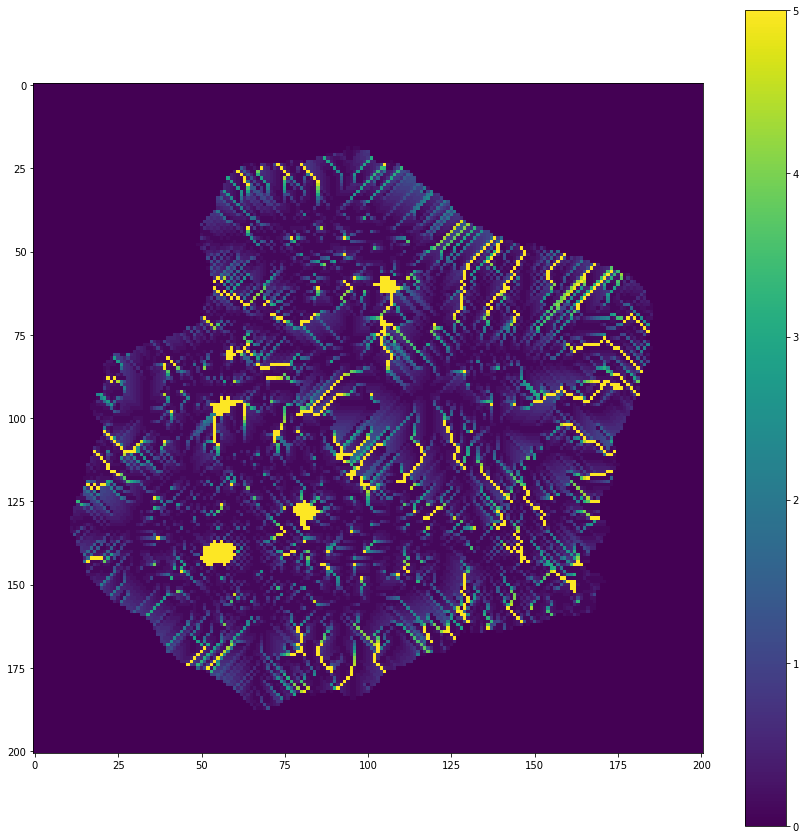

In [24]:
# Full Visualization
plt.figure(figsize=(15,15))
muffin = np.zeros((d+1,d+1))
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].vol > 5:
            muffin[i][j] = 5
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = 5
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
plt.imshow(muffin)
plt.colorbar();

In [25]:
# # Flow Visualization
# muffin = np.zeros((d+1,d+1))
# for i in range(len(biscuit_land)):
#     for j in range(len(biscuit_land)):
#         if pancake[i][j].vol > 10:
#             muffin[i][j] = 10
#         else:
#             muffin[i][j] = pancake[i][j].vol
# plt.imshow(muffin)
# plt.colorbar();

In [26]:
# # Pond Visualization
# cupcake = np.zeros((d+1, d+1))
# for pond in ponds:
#     for member in pond.members:
#         cupcake[member.y][member.x] = 1
# plt.imshow(cupcake)
# plt.colorbar();

In [27]:
# Re-Flow with pond volumes
for pixel in eclair:
    pixel.vol = 0.1
    pixel.pointer = get_pointer(pixel)
for pond in ponds:
    pond.vol_update()
    pond.pointer = get_pond_pointer(pond)
    pond.pointer.vol += pond.vol
for pixel in eclair:
    if pixel.pointer != pixel:
        pixel.pointer.vol += pixel.vol

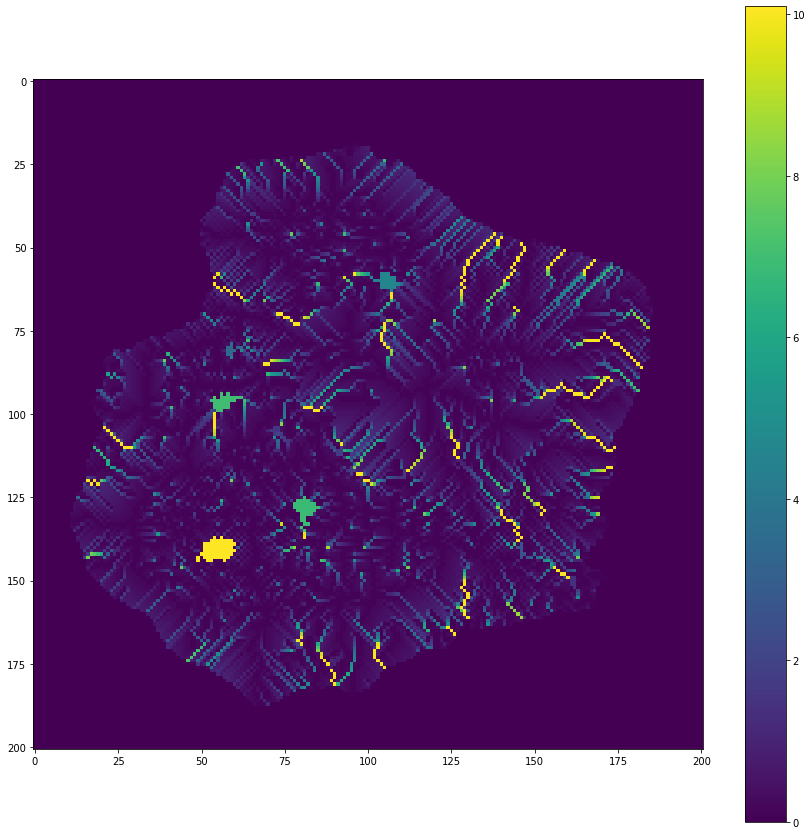

In [28]:
# Full Visualization
plt.figure(figsize=(15,15))
muffin = np.zeros((d+1,d+1))
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].vol > 10:
            muffin[i][j] = 10
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = pond.vol
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
plt.imshow(muffin)
plt.colorbar();

In [35]:
n = 0
previous_pancake = np.zeros(pancake.shape)
previous_pond = []
while (pond_pixels[:] != previous_pond[:]):
    previous_pancake = pancake
    previous_pond = pond_pixels[:]
    # Second Pond Creation
    for pixel in eclair:
        if (pixel.pointer == pixel) and (pixel.vol >= pond_cutoff) and (pixel.z >= 0) and (pixel not in pond_pixels):
            new_pond = Pond(pixel)
            ponds.append(new_pond)
            new_pond.rise()

    # Re-Flow with pond volumes
    for pixel in eclair:
        pixel.vol = 0.1
        pixel.pointer = get_pointer(pixel)
    for pond in ponds:
        pond.vol_update()
        pond.pointer = get_pond_pointer(pond)
        pond.pointer.vol += pond.vol
    for pixel in eclair:
        if pixel.pointer != pixel:
            pixel.pointer.vol += pixel.vol
    n += 1
    print(n)
print("final n:", n)

1
final n: 1


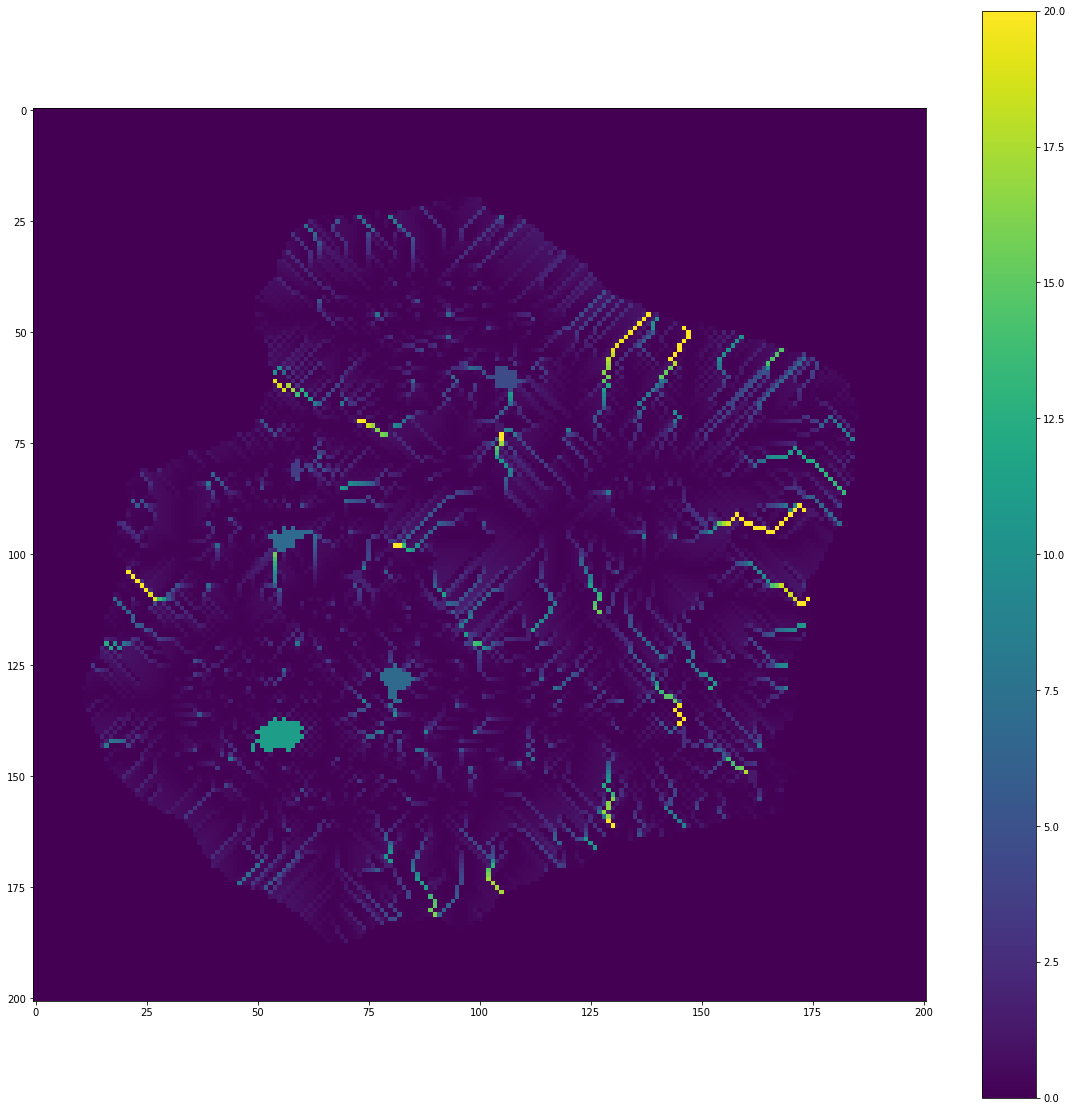

In [36]:
 # Full Visualization
plt.figure(figsize=(20,20))
muffin = np.zeros((d+1,d+1))
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].vol > 20:
            muffin[i][j] = 20
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = pond.vol
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
plt.imshow(muffin)
plt.colorbar();

In [37]:
pond_pointers = []
for pond in ponds:
    pond.pointer = get_pond_pointer(pond)
    pond_pointers.append(pond.pointer.pointer)

In [38]:
problem_children = []
for pixel in eclair:
    if (pixel in pond_pointers) and (pixel in pond_pixels):
        problem_children.append(pixel)

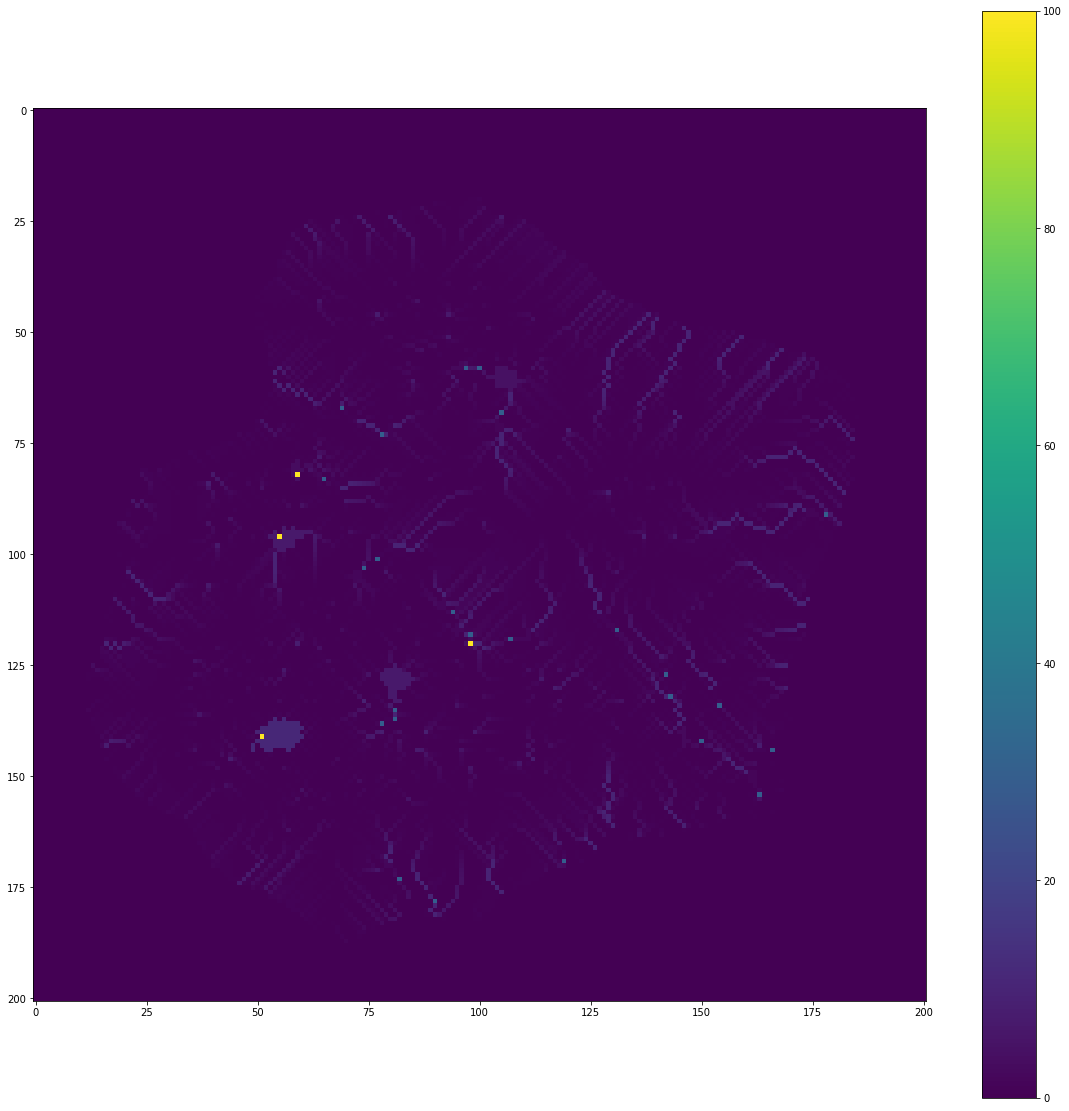

In [39]:
 # Full Visualization
plt.figure(figsize=(20,20))
muffin = np.zeros((d+1,d+1))
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].vol > 10:
            muffin[i][j] = 10
        else:
            muffin[i][j] = pancake[i][j].vol
for pond in ponds:
    for member in pond.members:
        muffin[member.y][member.x] = pond.vol
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j].z <= 0:
            muffin[i][j] = 0
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j] in pond_pointers:
            muffin[i][j] = 30
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if pancake[i][j] in problem_children:
            muffin[i][j] = 100
plt.imshow(muffin)
plt.colorbar();

In [41]:
for pixel in eclair:
    pixel.pointer = get_pointer(pixel)
    if (pixel.z <= pixel.pointer.z) and (pixel != pixel.pointer):
        print(pixel.to_string())

(128, 114, 0.42489841893315294)
(104, 71, 0.32746611684560767)
(105, 71, 0.32746611684560767)
(104, 72, 0.32746611684560767)
(110, 119, 0.3051636759936809)
(111, 118, 0.3051636759936809)
(111, 117, 0.3051636759936809)
(106, 58, 0.2665195210278034)
(105, 62, 0.2665195210278034)
(104, 62, 0.2665195210278034)
(103, 60, 0.2665195210278034)
(106, 62, 0.2665195210278034)
(106, 59, 0.2665195210278034)
(105, 58, 0.2665195210278034)
(104, 59, 0.2665195210278034)
(104, 58, 0.2665195210278034)
(108, 59, 0.2665195210278034)
(109, 61, 0.2665195210278034)
(105, 59, 0.2665195210278034)
(108, 62, 0.2665195210278034)
(108, 60, 0.2665195210278034)
(107, 62, 0.2665195210278034)
(142, 124, 0.2563531486690044)
(104, 60, 0.2665195210278034)
(107, 59, 0.2665195210278034)
(104, 61, 0.2665195210278034)
(107, 60, 0.2665195210278034)
(105, 60, 0.2665195210278034)
(106, 60, 0.2665195210278034)
(105, 61, 0.2665195210278034)
(106, 61, 0.2665195210278034)
(108, 61, 0.2665195210278034)
(80, 71, 0.24486757174134255)
(

(╯°□°)╯︵ ┻━┻